## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Datasets
def get_training_dataset(x_train, y_train, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 
                                                   'attention_mask': x_train[1]}, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=SEED)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 
                                                   'attention_mask': x_valid[1]}, y_valid))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 
                                                  'attention_mask': x_test[1]})
    dataset = dataset.batch(batch_size)
    return dataset

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Mixed precision
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
# XLA
tf.config.optimizer.set_jit(True)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
database_base_path = '/kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-2/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])

print('Train set samples: %d' % len(k_fold))
print('Validation set samples: %d' % len(valid_df))
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-2/fold_1.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-2/fold_2.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-2/fold_3.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-2/fold_4.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-2/fold_5.tar.gz

Train set samples: 400830
Validation set samples: 8000


,index,comment_text,toxic,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,1660057,"Well yes, that is what is stated when an organ...",0.000000,0,train,train,validation,train,train
1,450941,The article you linked to does not say that ne...,0.000000,0,train,train,train,train,validation
2,476670,"Rubbish, Brandon. Nothing stopped Comey of the...",0.833333,1,train,train,validation,train,train
3,7435,poster \n\nI have sent the e-mail. -Garrett,0.000000,0,train,train,validation,train,train
4,216053,== ECB exposure == \n\n I responded to a comme...,0.000000,0,train,train,validation,train,train


fold_1/
fold_1/x_valid.npy
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy


# Model parameters

In [5]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 5,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _= base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', dtype='float32', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(), metrics.AUC()])
    
    return model

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy').astype(np.float32)
    x_valid_ml = np.load(database_base_path + 'x_valid.npy')
    y_valid_ml = np.load(database_base_path + 'y_valid.npy').astype(np.float32)
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True, verbose=1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO),
                        validation_data=(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO)),
                        callbacks=[checkpoint, es],
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        verbose=2).history
        
    history_list.append(history)
    
    # Fine-tune on validation set
    print('\nFine-tune on validation set')
    n_steps2 = x_valid_ml.shape[1] // config['BATCH_SIZE']

    history2 = model.fit(get_training_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO),
                         steps_per_epoch=n_steps2,
#                          epochs=config['EPOCHS'],
                         epochs=2,
                         verbose=2).history
    
    # Make predictions
#     train_preds = model.predict(get_test_dataset(np.load(base_data_path + 'x_train.npy'), config['BATCH_SIZE'], AUTO))
#     valid_preds = model.predict(get_test_dataset(np.load(base_data_path + 'x_valid.npy'), config['BATCH_SIZE'], AUTO))
#     valid_ml_preds = model.predict(get_test_dataset(np.load(database_base_path + 'x_valid.npy'), config['BATCH_SIZE'], AUTO))
    
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)
#     valid_df['pred_%d' % (n_fold+1)] = np.round(valid_ml_preds)


FOLD: 1
Train for 2505 steps, validate for 62 steps
Epoch 1/5

Epoch 00001: val_loss improved from inf to 0.47013, saving model to model_fold_1.h5
2505/2505 - 1205s - loss: 0.4951 - binary_accuracy: 0.5500 - auc: 0.7405 - val_loss: 0.4701 - val_binary_accuracy: 0.8459 - val_auc: 0.5000
Epoch 2/5

Epoch 00002: val_loss improved from 0.47013 to 0.26025, saving model to model_fold_1.h5
2505/2505 - 1036s - loss: 0.4968 - binary_accuracy: 0.5486 - auc: 0.7403 - val_loss: 0.2603 - val_binary_accuracy: 0.8726 - val_auc: 0.9156
Epoch 3/5

Epoch 00003: val_loss improved from 0.26025 to 0.24922, saving model to model_fold_1.h5
2505/2505 - 1037s - loss: 0.3234 - binary_accuracy: 0.5797 - auc: 0.9388 - val_loss: 0.2492 - val_binary_accuracy: 0.8718 - val_auc: 0.9177
Epoch 4/5

Epoch 00004: val_loss did not improve from 0.24922
Restoring model weights from the end of the best epoch.
2505/2505 - 1050s - loss: 0.3132 - binary_accuracy: 0.5827 - auc: 0.9449 - val_loss: 0.2569 - val_binary_accuracy: 0

## Model loss graph

Fold: 1


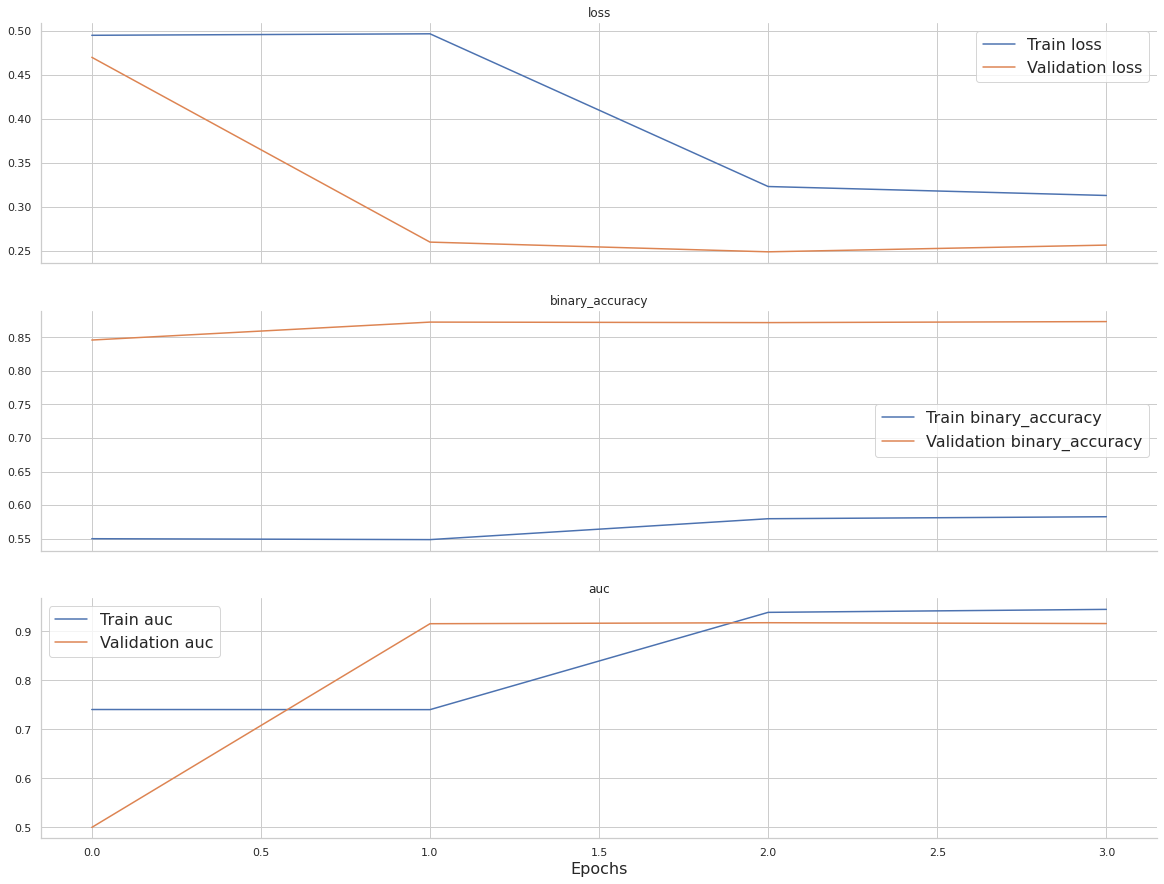

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
# display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

# Confusion matrix

In [10]:
# for n_fold in range(config['N_FOLDS']):
#     print('Fold: %d' % (n_fold+1))
#     train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
#     validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
#     plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
#                           validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Model evaluation by language

In [11]:
# display(evaluate_model_lang(valid_df, config['N_FOLDS']).style.applymap(color_map))

# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,"Well yes, that is what is stated when an organization switches from a defined benefit plan to a defined contribution...",0.000000
1,The article you linked to does not say that nearly 70% of transgender people have an underlying psychological disord...,0.000000
2,"Rubbish, Brandon. Nothing stopped Comey of the FBI of dumping the phony story about a new investigation in Hillary's...",0.833333
3,poster \n\nI have sent the e-mail. -Garrett,0.000000
4,== ECB exposure == \n\n I responded to a comment of yours here. Cheers.,0.000000
5,$10.5 Million for the misunderstood young IED bomb making/throwing Al-Qaeda soldier.. Wow.\nBut how about the bright...,0.200000
6,Is Trump allowed 12 firings a year?,0.000000
7,"I am a citizen of California. The concept of ""United States of America"" is no longer tenable. It is now unworkable d...",0.166667
8,The Iditarod really needs a TV contract with somebody like Mav tv would be great. This is needed to grow the interes...,0.000000
9,"Corspefucking Art\n\nI used their offical website as help to gte al information right. Therefore, some sentences wer...",1.000000


Multilingual validation set


,comment_text,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0


# Test set predictions

In [13]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
model_path_list.sort()
print('Models to predict:')
print(*model_path_list, sep = "\n")

Models to predict:
/kaggle/working/model_fold_1.h5


In [14]:
x_test = np.load(database_base_path + 'x_test.npy')
NUM_TEST_IMAGES = x_test.shape[1]
test_preds = np.zeros((NUM_TEST_IMAGES, 1))

for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(model_path)
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        model.load_weights(model_path)

    test_preds += model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO)) / len(model_path_list)

/kaggle/working/model_fold_1.h5


In [15]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.212488
std,18421.082026,0.280513
min,0.000000,0.000003
25%,15952.750000,0.001385
50%,31905.500000,0.029634
75%,47858.250000,0.416155
max,63811.000000,0.999886


,id,toxic
0,0,0.003605
1,1,0.013339
2,2,0.203749
3,3,0.001203
4,4,0.000112
5,5,0.039856
6,6,0.000060
7,7,0.005428
8,8,0.694034
9,9,0.447893
